# E - End-to-End ML Part 4: Gradient Boosting + weitere Features

Environment für dieses Notebook: `ads-ml-full` (*requirements-py3.11-ads-ml-full.txt*).


## Daten einlesen

In [23]:
from repml.datasets.trees_ber import prepare_trees_ber

data, labeled, unlabeled = prepare_trees_ber()

### Neues Feature: Lat-Lon-Tile

In [24]:
labeled["lat_section"].cat.categories

Index([52.4, 52.5, 52.6], dtype='float64')

In [25]:
labeled["lon_section"].cat.categories

Index([13.1, 13.2, 13.3, 13.4, 13.5, 13.6, 13.7], dtype='float64')

In [26]:
labeled["lat_lon_tile"].cat.categories

Index(['52.4-13.1', '52.4-13.3', '52.4-13.4', '52.4-13.5', '52.4-13.6',
       '52.4-13.7', '52.5-13.1', '52.5-13.2', '52.5-13.3', '52.5-13.4',
       '52.5-13.5', '52.5-13.6', '52.6-13.2', '52.6-13.3', '52.6-13.4',
       '52.6-13.5', '52.6-13.6', 'rare'],
      dtype='object')

In [27]:
print(
    f"Latitude Scheiben: {len(labeled['lat_section'].cat.categories)}\n"
    f"Longitude Scheiben: {len(labeled['lon_section'].cat.categories)}\n"
    f"Tiles: {len(labeled['lat_lon_tile'].cat.categories)}\n"
)

Latitude Scheiben: 3
Longitude Scheiben: 7
Tiles: 18



### Schneller Check mit einem Subset?

Kommentiert die nächste Zelle aus um mit einem Subset zu arbeiten. Damit kann die Entwicklung wesentlich schneller gehen.

In [28]:
# import pandas as pd
# # from repml.datasets.trees_ber import create_ber_subset

# # create_ber_subset()

# labeled = pd.read_parquet("../data/subset_baumkataster_berlin_2023.parquet")

In [29]:
labeled.shape

(275384, 25)

## Trainings- und Testdaten

In [30]:
from sklearn.model_selection import train_test_split

y = "pflanzjahr"
X = labeled.columns.to_list()
X.remove(y)
train_data, test_data = train_test_split(labeled, test_size=0.2, random_state=42)

### Alle (möglichen) Features

In [31]:
num_cols_4 = [
    "kronedurch",
    "stammumfg",
    "baumhoehe",
    "hoehe_zu_krone",
    "hoehe_zu_stamm",
]

cat_cols_4 = [
    "bezirk",
    "baumart",
    "art_dtsch",
    "art_bot",
    "gattung_deutsch",
    "gattung",
    "art_dtsch_infrequent",
    "art_bot_infrequent",
    "gattung_deutsch_infrequent",
    "gattung_infrequent",
    "namenr",
    "namenr_nonum",
    "lat_lon_tile",
]
cols_set_4 = [*num_cols_4, *cat_cols_4]

num_cols_4_ix = [cols_set_4.index(col) for col in num_cols_4]
cat_cols_4_ix = [cols_set_4.index(col) for col in cat_cols_4]

In [32]:
cat_cols_4_ix

[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]

### Versuch 4: Gradient Boosting + mehr kategorische Features

In [33]:
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

ct_4a = ColumnTransformer(
    transformers=[
        ("imp", IterativeImputer(random_state=42), num_cols_4_ix),
    ],
    remainder="passthrough",
)

In [34]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

ct_4b = ColumnTransformer(
    transformers=[
        ("scale", StandardScaler(), num_cols_4_ix),
        (
            "ohe",
            OneHotEncoder(handle_unknown="ignore", sparse_output=True),
            cat_cols_4_ix,
        ),
    ],
)

In [35]:
from sklearn.ensemble import GradientBoostingRegressor

est_4 = GradientBoostingRegressor(
    subsample=0.9,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
)

In [36]:
from sklearn.pipeline import Pipeline

pipeline_4 = Pipeline(steps=[("prep_a", ct_4a), ("prep_b", ct_4b), ("model", est_4)])

In [37]:
pipeline_4

Pipeline(steps=[('prep_a',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('imp',
                                                  IterativeImputer(random_state=42),
                                                  [0, 1, 2, 3, 4])])),
                ('prep_b',
                 ColumnTransformer(transformers=[('scale', StandardScaler(),
                                                  [0, 1, 2, 3, 4]),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  [5, 6, 7, 8, 9, 10, 11, 12,
                                                   13, 14, 15, 16, 17])])),
                ('model',
                 GradientBoostingRegressor(max_depth=4, min_samples_leaf=5,
                                           min_samples_split=10,
                                           random_state=42, subsample=0.9))])

In [38]:
%%time
from sklearn.model_selection import cross_val_score

cross_val_score(estimator=pipeline_4, X=train_data[cols_set_4], y=train_data[y], cv=5, n_jobs=3)

CPU times: user 3.12 s, sys: 1.06 s, total: 4.18 s
Wall time: 9min 10s


array([0.77897287, 0.78095159, 0.77394306, 0.77950306, 0.77699401])

In [41]:
import os
from dotenv import load_dotenv
import mlflow

load_dotenv()

mlflow.set_tracking_uri(os.getenv("LOCAL_MLFLOW_TRACKING_URI"))  # "sqlite:///mlflow.db"
mlflow.set_experiment("4E-e2e-part4")
mlflow.sklearn.autolog(log_models=False, log_datasets=False, silent=True)

In [42]:
%%time
pipeline_4.fit(X=train_data[cols_set_4], y=train_data[y])

CPU times: user 3min 18s, sys: 9.83 s, total: 3min 28s
Wall time: 4min


Pipeline(steps=[('prep_a',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('imp',
                                                  IterativeImputer(random_state=42),
                                                  [0, 1, 2, 3, 4])])),
                ('prep_b',
                 ColumnTransformer(transformers=[('scale', StandardScaler(),
                                                  [0, 1, 2, 3, 4]),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  [5, 6, 7, 8, 9, 10, 11, 12,
                                                   13, 14, 15, 16, 17])])),
                ('model',
                 GradientBoostingRegressor(max_depth=4, min_samples_leaf=5,
                                           min_samples_split=10,
                                           random_state=42, subsample=0.9))])

In [43]:
pipeline_4.score(X=test_data[cols_set_4], y=test_data[y])

0.785340050675311

#### Fluch der Dimensionalität

In [44]:
pipeline_4[:-1].transform(X=test_data[cols_set_4])

<55077x6150 sparse matrix of type '<class 'numpy.float64'>'
	with 991335 stored elements in Compressed Sparse Row format>

Einige der Features sind hochkardinal, das führt zu einer unglaublich großen Feature Matrix. Der GradientBoostingRegressor kann out-of-the-box noch damit rechnen, weitere Verarbeitung, die eine Matrix nicht im SciPy Sparse Matrix Format erfordern würde, sind aber deutlich erschwert!

## XAI

In [45]:
transformed_test_4 = pipeline_4[:-1].transform(test_data[cols_set_4]).toarray()

In [46]:
transformed_test_4

array([[ 0.65214445,  0.92879373,  0.52628907, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.22774784,  2.80245527,  1.63421618, ...,  0.        ,
         0.        ,  0.        ],
       [-0.46103926, -0.49176012, -0.87690592, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.97820172, -0.18560627,  1.16338078, ...,  0.        ,
         0.        ,  0.        ],
       [-0.71962049, -0.22234474,  0.37865513, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.27860813,  0.48793219,  0.06476487, ...,  0.        ,
         0.        ,  0.        ]])

In [47]:
import shap

explainer_4 = shap.TreeExplainer(pipeline_4.named_steps["model"])
shap_values = explainer_4.shap_values(transformed_test_4)

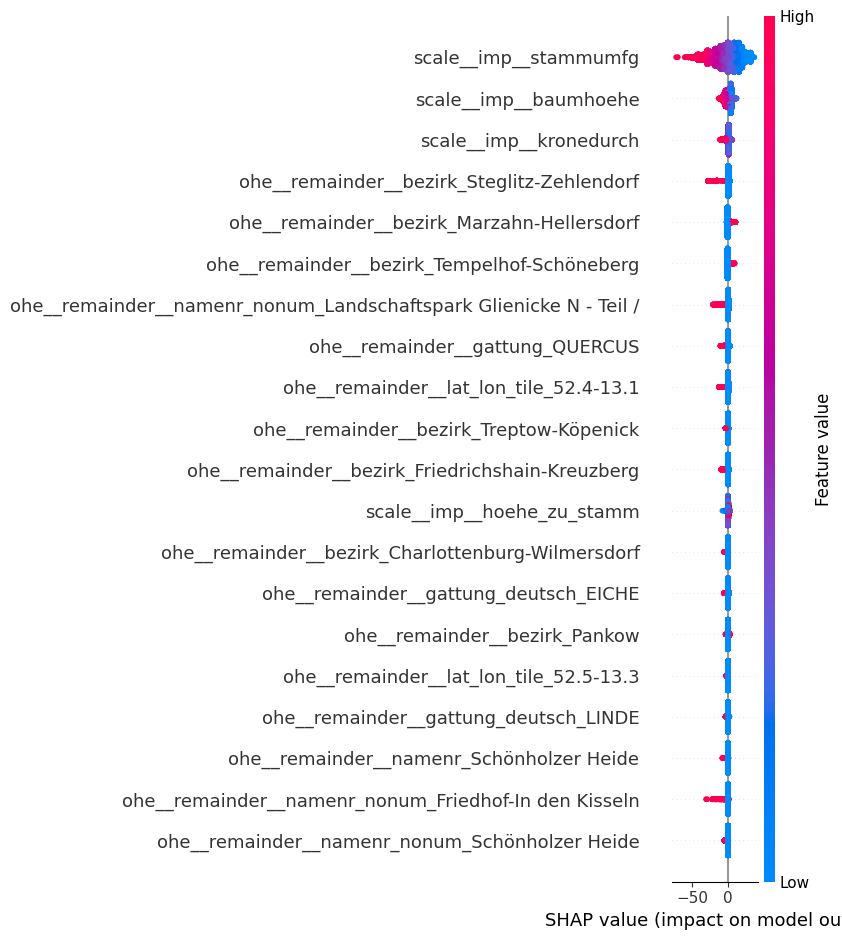

In [48]:
shap.summary_plot(
    shap_values=shap_values,
    features=transformed_test_4,
    feature_names=pipeline_4[:-1].get_feature_names_out(),
)